<a href="https://colab.research.google.com/github/ngnquanq/Food-classification/blob/main/food_classify_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Incerease the model capacity**

1. Batch normalization
2. Skip connection
3. Change initializer
4. Change activation function

# **Incerease the model generalization**

1. Add noise
2. batch normalization
3. dropout
4. data augmentation
5. kernal regularization

In [ ]:
#Import + setting up device agnostic code
import torch
from torch import nn
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
!nvidia-smi

/bin/bash: nvidia-smi: command not found


1. Get data

In [ ]:
import requests
import zipfile
from pathlib import Path

#stup Path to a data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

#if the image folder doesn't exist, download and prepare it
if image_path.is_dir():
  print("already exists")
else:
  print("download it")
  image_path.mkdir(parents  =True, exist_ok = True)

#Download pizza, steak and sushi data
with open(data_path/"pizza_steak_sushi.zip", "wb") as f: #Always get the raws link
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("Downloading pizza, steak, sushi data...")
  f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
  print("Unzipping pizza, steak, sushi data...") 
  zip_ref.extractall(image_path)

download it
Unzipping pizza, steak, sushi data...


2. Walkthrough the directory

In [ ]:
import os
def walk_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} image in {dirpath}")

In [ ]:
walk_through_dir(image_path)

There are 2 directories and 0 image in data/pizza_steak_sushi
There are 3 directories and 0 image in data/pizza_steak_sushi/train
There are 0 directories and 78 image in data/pizza_steak_sushi/train/pizza
There are 0 directories and 72 image in data/pizza_steak_sushi/train/sushi
There are 0 directories and 75 image in data/pizza_steak_sushi/train/steak
There are 3 directories and 0 image in data/pizza_steak_sushi/test
There are 0 directories and 25 image in data/pizza_steak_sushi/test/pizza
There are 0 directories and 31 image in data/pizza_steak_sushi/test/sushi
There are 0 directories and 19 image in data/pizza_steak_sushi/test/steak


a small amount of image, should try on a larger one

In [ ]:
#Setup train and testing paths
train_dir = image_path/"train"
test_dir = image_path /"test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

Visualize the image

data/pizza_steak_sushi/test/pizza/930553.jpg
pizza
Random image path :data/pizza_steak_sushi/test/pizza/930553.jpg
Image class:pizza
Image height: 512
Image width: 306


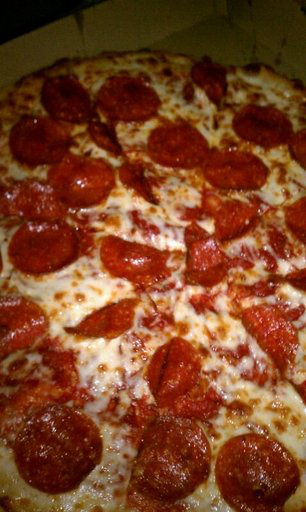

In [ ]:
import random
from PIL import Image

#set seed
#random.seed(42)

#get all the image paths
image_path_list = list(image_path.glob("*/*/*.jpg")) #Each star is a directory

#pick a random image path
random_image_path = random.choice(image_path_list)
print(random_image_path)

#get image class from path name
image_class = random_image_path.parent.stem
print(image_class)

#open image
img = Image.open(random_image_path)

#print metada
print(f"Random image path :{random_image_path}")
print(f"Image class:{image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

Text(0.5, 1.0, 'Image class: pizza | Image shape: (512, 306, 3)')

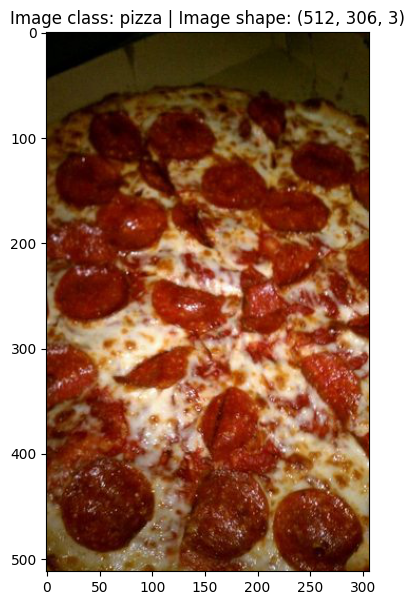

In [ ]:
#Try to visualize and image with matplotlib
import numpy as np 
import matplotlib.pyplot as plt 

#Turn the image into an array
img_as_array = np.asarray(img)

#plot the image with matplotlib
plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape}")

In [ ]:
#it's numpy array
img_as_array

array([[[ 1,  1,  0],
        [ 1,  1,  0],
        [ 1,  1,  0],
        ...,
        [37, 17,  8],
        [34, 22,  6],
        [34, 22,  6]],

       [[ 1,  1,  0],
        [ 1,  1,  0],
        [ 1,  1,  0],
        ...,
        [32, 14,  4],
        [29, 21,  2],
        [29, 21,  2]],

       [[ 1,  1,  0],
        [ 1,  1,  0],
        [ 1,  1,  0],
        ...,
        [31, 14,  6],
        [34, 26,  5],
        [34, 26,  5]],

       ...,

       [[87, 57,  7],
        [88, 57, 11],
        [79, 47,  9],
        ...,
        [90, 26,  1],
        [79, 23,  0],
        [79, 23,  0]],

       [[92, 63,  7],
        [91, 61,  9],
        [86, 53, 10],
        ...,
        [85, 20,  2],
        [74, 16,  2],
        [73, 15,  1]],

       [[88, 59,  1],
        [84, 54,  0],
        [83, 50,  5],
        ...,
        [82, 14,  1],
        [74, 15,  7],
        [73, 14,  6]]], dtype=uint8)

3. Transform the data (to tensor + image augmentation)

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [ ]:
#Write a transform for image
data_transform_train = transforms.Compose([
    #Resize our image to 64x64
    transforms.Resize(size=(64,64)),
    #Data augmentation
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.ColorJitter(brightness=0.01, contrast=0.01, saturation=0.0, hue=0.1),
    #Turn the image into a torch tensor
    transforms.ToTensor() 
])

In [ ]:
#Write a transform for image
data_transform_test = transforms.Compose([
    #Resize our image to 64x64
    transforms.Resize(size=(64,64)),
    #Data augmentation
    #transforms.RandomHorizontalFlip(p=0.3),
    #transforms.RandomVerticalFlip(p=0.2),
    #transforms.ColorJitter(brightness=0.01, contrast=0.01, saturation=0.0, hue=0.1),
    #Turn the image into a torch tensor
    transforms.ToTensor() 
])

In [ ]:
#Loading image data using torchvision.datasets.ImageFolders

In [ ]:
#use ImageFolder to create dataset
from torchvision import datasets
train_data = datasets.ImageFolder(root = train_dir,
                                  transform = data_transform_train, #a transform for the data
                                  target_transform=None)#a transform for the label/target

test_data = datasets.ImageFolder(root = test_dir,
                                 transform = data_transform_test,#Differnce from vid
                                 target_transform=None)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.3)
                RandomVerticalFlip(p=0.2)
                ColorJitter(brightness=(0.99, 1.01), contrast=(0.99, 1.01), saturation=None, hue=(-0.1, 0.1))
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
            ))

In [ ]:
print(type(train_data.class_to_idx))
print(train_data.class_to_idx)

<class 'dict'>
{'pizza': 0, 'steak': 1, 'sushi': 2}


In [ ]:
class_dict = train_data.class_to_idx
class_names = train_data.classes

In [ ]:
#Print out some information
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n {img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype:{img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")
print(f"Food type: {class_names[label]}")

Image tensor:
 tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0941, 0.0980, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0941, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0902, 0.0941, 0.0980],
         ...,
         [0.1922, 0.1765, 0.1804,  ..., 0.1255, 0.1098, 0.1098],
         [0.1882, 0.1804, 0.1843,  ..., 0.1098, 0.0941, 0.0863],
         [0.1843, 0.1843, 0.1882,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0196, 0.0196, 0.0196,  ..., 0.0745, 0.0706, 0.0745],
         [0.0196, 0.0157, 0.0196,  ..., 0.0745, 0.0706, 0.0706],
         [0.0196, 0.0157, 0.0157,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1490, 0.1333, 0.1294],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1059]],

        [[0.0275, 0.0275, 0.0314,  ..., 0.0980, 0.1020, 0.1137],
         [0.0275, 0.0196, 0.0275,  ..., 0.0980, 0.0980, 0.1059],
         [0.0196, 0.0157, 0.0157,  ..., 0.0

OG shape: torch.Size([3, 64, 64])
Permute shape: torch.Size([64, 64, 3])


Text(0.5, 1.0, 'pizza')

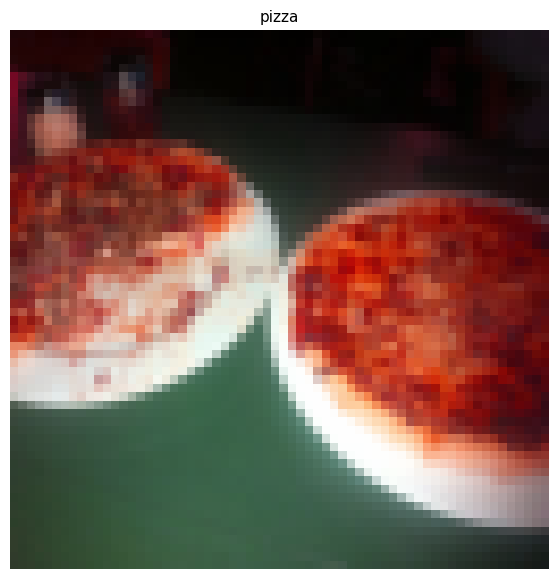

In [ ]:
#Rearrange the order dimensions
img_permute = img.permute(1,2,0)
#Print out different shapes
print(f"OG shape: {img.shape}")
print(f"Permute shape: {img_permute.shape}")
#Plot the image
plt.figure(figsize=(10,7))
plt.imshow(img_permute)
plt.axis("off")
plt.title(class_names[label], fontsize=11)

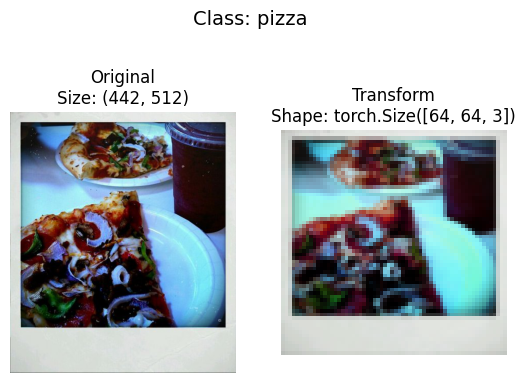

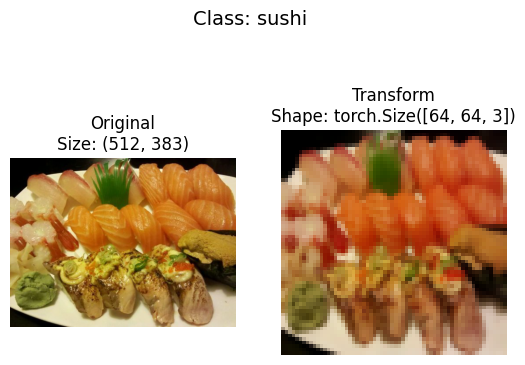

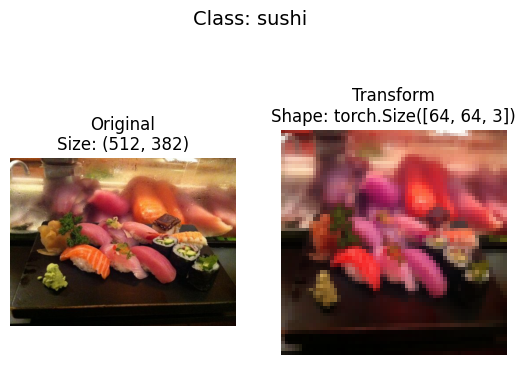

In [ ]:
#a fuction to plot some random image (after transformed)
def plot_transformed_images(image_paths, transform, n=3, seed=None):
  """Select random images from a path images and 
  loads/transforms them then plots the original
  vs the transformed version."""
  random.seed(seed)
  random_image_paths = random.sample(image_paths, k= n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows = 1, ncols=2)
      ax[0].imshow(f) 
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

      #Transform and plot target image
      transform_image = transform(f).permute(1,2,0) #Note we will need to change shape for plt
      #Have to permute because the img size is (HWC) but plt shape is (CHW)
      #Then we have to permute
      ax[1].imshow(transform_image)
      ax[1].set_title(f"Transform\nShape: {transform_image.shape}")
      ax[1].axis(False)

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize = 14)

plot_transformed_images(image_paths = image_path_list, 
                        transform = data_transform,
                        n=3,
                        seed=None)

4. Turn loaded images into dataloader


In [ ]:
import os
os.cpu_count()

2

In [ ]:
#Turn datasets into dataloader
import os
BATCH_SIZE = 64
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(dataset = train_data,
                                        batch_size = BATCH_SIZE,
                                        shuffle = True,
                                        num_workers = NUM_WORKERS)

test_dataloader_simple = DataLoader(dataset = test_data,
                                        batch_size = BATCH_SIZE,
                                        shuffle = False,
                                        num_workers = NUM_WORKERS)

In [ ]:
#print out the shape
img, label = next(iter(train_dataloader_augmented))
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([64, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([64])


5. Some useful metrics + package + function

In [ ]:
#For train
#Create train_step()
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer:torch.optim.Optimizer,
               device= device):
  #put the model in train mode:
  model.train()
  #setup train loss and train accuracy values
  train_loss, train_acc = 0,0
  #loop through data loader data batches
  for batch, (X,y) in enumerate(dataloader):
    #Send data to the target device
    X, y = X.to(device), y.to(device)
    #forward pass
    y_pred= model(X)
    #loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()
    #zero grad
    optimizer.zero_grad()
    #backpropagation
    loss.backward()
    #optimizer step
    optimizer.step()
    #calculate accuracy metric
    y_pred_class = torch.argmax(y_pred,dim=1)
    train_acc += ((y_pred_class==y).sum().item() * (len(y_pred)**(-1)))

  
  #adjust metrics to get average loss and accuracy per batch
  train_loss =train_loss / len(dataloader)
  train_acc = train_acc /len(dataloader)
  return train_loss, train_acc

In [ ]:
#For test
#Create a test step
def test_step(model,
              dataloader,
              loss_fn,
              device=device):
  #put model in eval mode
  model.eval()
  #setup test loss and test accuracy values
  test_loss, test_acc =0,0
  #turn on reference mode
  with torch.inference_mode():
    #loop through dataloader batches
    for batch, (X,y) in enumerate(dataloader):
      #send data to the target device
      X, y = X.to(device), y.to(device)
      #forward pass
      test_pred_logits = model(X)
      #cal loss
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()
      #calculate the accuaracy
      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += (((test_pred_labels==y).sum().item())/len(test_pred_labels))

  #Adjust metrics to get the average loss per and accuracy per batch
  test_loss =test_loss/len(dataloader)
  test_acc =test_acc/len(dataloader)
  return test_loss, test_acc

In [ ]:
#whole process
from tqdm.auto import tqdm

#1. Create a train function that take various model parameters
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int =5,
          device =device):
  #2. create empty result dictionary
  results = {"train_loss": [],
           "train_acc": [],
           "test_loss": [],
           "test_acc": []}

  #loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model = model,
                                       dataloader = train_dataloader,
                                       loss_fn = loss_fn,
                                       optimizer=  optimizer,
                                       device= device)
    test_loss, test_acc = test_step(model = model,
                                      dataloader = test_dataloader,
                                      loss_fn = loss_fn,
                                      device = device)
    #Print out what's happening
    print(f"Epoch: {epoch} |Train loss: {train_loss:.4f}|Test loss:{test_loss:.4f}|Test acc:{test_acc:.2f}|Train acc:{train_acc:.2f}")

    #Update results dictionary
    results["train_loss"].append(train_loss) 
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  
  #Return
  return results

In [ ]:
#the loss curve
def plot_loss_curves(results: dict[str, list[float]]):
  """Plot the training curves of a results dictionary."""
  loss = results["train_loss"]
  test_loss = results["test_loss"]

  accuracy = results["train_acc"]
  test_accuracy = results["test_acc"]

  epochs = range(len(results["train_loss"]))

  plt.figure(figsize = (15,7))

  plt.subplot(1,2,1)
  plt.plot(epochs, loss, label="train_loss")
  plt.plot(epochs, test_loss, label = "test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs") 
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(epochs, accuracy, label = "train_accuracy")
  plt.plot(epochs, test_accuracy, label = "test_accuracy")
  plt.legend()
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()


In [ ]:
#using torchinfo to summarize the model
!pip install torchinfo
from torchinfo import summary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torchvision

In [ ]:
def pred_and_plot_image(model,
                        image_path,
                        class_names,
                        transform,
                        device = device):
  #Load in the image
  og_target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)
  #Divide the image pixel values by 155
  target_image = og_target_image / 255.
  #Transform if nesscary
  if transform:
    target_image = transform(target_image)
  #model to device
  model.to(device) 
  target_image.to(device)
  #eval
  model.eval()
  with torch.inference_mode():
    target_image = target_image.unsqueeze(0)
    #make prediction
    target_image_pred = model(target_image.to(device))
    target_image_label = target_image_pred.argmax()
    label = class_names[target_image_label]
    print(label)

  plt.imshow(torchvision.io.read_image(str(image_path)).permute(1,2,0))

6. Experiment 1: 

In [ ]:
class CNNmodelV0(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int) -> None:
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels = input_shape,
                  out_channels = hidden_units,
                  kernel_size =3,
                  stride = 1,
                  padding =1),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size =3,
                  stride = 1,
                  padding =1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2,
                     stride =2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size =3,
                  stride = 1,
                  padding =1),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size =3,
                  stride = 1,
                  padding =1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2,
                     stride =2)
    )
    self.classifier  = nn.Sequential(
        nn.Flatten(start_dim = 1),
        nn.Linear(in_features = hidden_units*16*16,#Tips, train first, fix later, to check what's this required
                  out_features = output_shape)
    )
  def forward(self, x):
    x = self.conv_block_1(x)
    #print(x.shape)
    x = self.conv_block_2(x)
    #print(x.shape)
    x = self.classifier(x)
    #print(x.shape)
    return x #Prefer the layer with layer one like linear model


In [ ]:
torch.manual_seed(42)
model_0 = CNNmodelV0(input_shape = 3,
                  hidden_units = 10,
                  output_shape = 3).to(device)

In [ ]:
model_0

CNNmodelV0(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [ ]:
summary(model_0, input_size = [32,3,64,64])

/usr/local/lib/python3.9/dist-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/usr/local/lib/python3.9/dist-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type:depth-idx)                   Output Shape              Param #
CNNmodelV0                               [32, 3]                   --
├─Sequential: 1-1                        [32, 10, 32, 32]          --
│    └─Conv2d: 2-1                       [32, 10, 64, 64]          280
│    └─ReLU: 2-2                         [32, 10, 64, 64]          --
│    └─Conv2d: 2-3                       [32, 10, 64, 64]          910
│    └─ReLU: 2-4                         [32, 10, 64, 64]          --
│    └─MaxPool2d: 2-5                    [32, 10, 32, 32]          --
├─Sequential: 1-2                        [32, 10, 16, 16]          --
│    └─Conv2d: 2-6                       [32, 10, 32, 32]          910
│    └─ReLU: 2-7                         [32, 10, 32, 32]          --
│    └─Conv2d: 2-8                       [32, 10, 32, 32]          910
│    └─ReLU: 2-9                         [32, 10, 32, 32]          --
│    └─MaxPool2d: 2-10                   [32, 10, 16, 16]          --
├─Sequentia

In [ ]:
#setup loss + optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(),
                             lr=0.02)

In [ ]:
#Train model 1
from timeit import default_timer as timer
start_timer = timer()
model_0_result = train(model = model_0,
                        train_dataloader= train_dataloader_augmented,
                        test_dataloader= test_dataloader_simple,
                        optimizer = optimizer,
                        loss_fn= loss_fn,
                        epochs = 30,
                        device =device)
end_timer = timer()
print(f"Total training time: {end_timer-start_timer:.3f}")

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 0 |Train loss: 1.0986|Test loss:1.1065|Test acc:0.16%|Train acc:0.30%
Epoch: 1 |Train loss: 1.0984|Test loss:1.1065|Test acc:0.16%|Train acc:0.29%
Epoch: 2 |Train loss: 1.0988|Test loss:1.1065|Test acc:0.16%|Train acc:0.27%
Epoch: 3 |Train loss: 1.0982|Test loss:1.1065|Test acc:0.16%|Train acc:0.32%
Epoch: 4 |Train loss: 1.0983|Test loss:1.1065|Test acc:0.16%|Train acc:0.29%
Epoch: 5 |Train loss: 1.0985|Test loss:1.1065|Test acc:0.16%|Train acc:0.29%
Epoch: 6 |Train loss: 1.0984|Test loss:1.1065|Test acc:0.16%|Train acc:0.27%
Epoch: 7 |Train loss: 1.0983|Test loss:1.1065|Test acc:0.16%|Train acc:0.31%
Epoch: 8 |Train loss: 1.0987|Test loss:1.1065|Test acc:0.16%|Train acc:0.25%
Epoch: 9 |Train loss: 1.0985|Test loss:1.1065|Test acc:0.16%|Train acc:0.31%
Epoch: 10 |Train loss: 1.0984|Test loss:1.1065|Test acc:0.16%|Train acc:0.29%
Epoch: 11 |Train loss: 1.0984|Test loss:1.1065|Test acc:0.16%|Train acc:0.27%
Epoch: 12 |Train loss: 1.0983|Test loss:1.1065|Test acc:0.16%|Train acc:0.

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fae94b73c10>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch: 28 |Train loss: 1.0982|Test loss:1.1065|Test acc:0.16%|Train acc:0.32%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fae94b73c10>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive

assert self._parent_pid == os.getpid(), 'can only test a child process'    
AssertionError: can only test a child process


Epoch: 29 |Train loss: 1.0989|Test loss:1.1065|Test acc:0.16%|Train acc:0.28%
Total training time: 101.658


The metrics show that this model is very bad, need to rebuild

In [ ]:
class CNNmodelV1(nn.Module):
  def __init__(self,
               input_shape: int,
               output_shape: int) -> None:
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels = input_shape,
                  out_channels = 32,
                  kernel_size =3,
                  stride = 1,
                  padding ='valid'),
        nn.BatchNorm2d(num_features=32), # added batch normalization layer
        nn.ReLU(),
        nn.Conv2d(in_channels = 32,
                  out_channels = 64,
                  kernel_size =3,
                  stride = 1,
                  padding ='valid'),
        nn.BatchNorm2d(num_features=64), # added batch normalization layer
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2,
                     stride =2)
    )
    self.classifier  = nn.Sequential(
        nn.Flatten(start_dim = 1),
        nn.Linear(in_features = 147456,#Tips, train first, fix later, to check what's this required
                  out_features = output_shape)
    )
  def forward(self, x):
    x = self.conv_block_1(x)
    #print(x.shape)
    x = self.conv_block_2(x)
    #print(x.shape)
    x = self.classifier(x)
    #print(x.shape)
    return x #Prefer the layer with layer one like linear model


In [ ]:
torch.manual_seed(42)
model_1 = CNNmodelV1(3,3)

In [ ]:
#setup loss + optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(),
                             lr=0.02)

In [ ]:
#Train model 1
from timeit import default_timer as timer
start_timer = timer()
model_1_result = train(model = model_1,
                        train_dataloader= train_dataloader_augmented,
                        test_dataloader= test_dataloader_simple,
                        optimizer = optimizer,
                        loss_fn= loss_fn,
                        epochs = 30,
                        device =device)
end_timer = timer()
print(f"Total training time: {end_timer-start_timer:.3f}")

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 0 |Train loss: 1.3069|Test loss:1.1244|Test acc:0.16%|Train acc:0.35%
Epoch: 1 |Train loss: 1.2524|Test loss:1.1440|Test acc:0.21%|Train acc:0.33%
Epoch: 2 |Train loss: 1.2599|Test loss:1.1593|Test acc:0.21%|Train acc:0.36%
Epoch: 3 |Train loss: 1.2754|Test loss:1.1695|Test acc:0.21%|Train acc:0.36%
Epoch: 4 |Train loss: 1.2425|Test loss:1.1779|Test acc:0.22%|Train acc:0.36%
Epoch: 5 |Train loss: 1.2547|Test loss:1.1921|Test acc:0.22%|Train acc:0.33%
Epoch: 6 |Train loss: 1.2585|Test loss:1.2180|Test acc:0.22%|Train acc:0.39%
Epoch: 7 |Train loss: 1.2800|Test loss:1.2514|Test acc:0.21%|Train acc:0.33%
Epoch: 8 |Train loss: 1.2867|Test loss:1.3020|Test acc:0.22%|Train acc:0.35%
Epoch: 9 |Train loss: 1.2522|Test loss:1.3493|Test acc:0.21%|Train acc:0.34%
Epoch: 10 |Train loss: 1.3006|Test loss:1.3969|Test acc:0.21%|Train acc:0.31%
Epoch: 11 |Train loss: 1.2433|Test loss:1.4380|Test acc:0.20%|Train acc:0.34%
Epoch: 12 |Train loss: 1.2170|Test loss:1.4734|Test acc:0.21%|Train acc:0.

In [ ]:
summary(model_1, input_size = [64,3,64,64])

Still bad

In [ ]:
#Combine data
from torch.utils.data import ConcatDataset

train_data_original = datasets.ImageFolder(root = train_dir,
                                  transform = transforms.Compose([transforms.Resize(size=(64,64)),transforms.ToTensor()]),
                                  target_transform=None)

train_data_augmented = datasets.ImageFolder(root = train_dir,
                                  transform = data_transform_train,
                                  target_transform=None)

train_data_combined = ConcatDataset([train_data_original, train_data_augmented])

train_dataloader_combined = DataLoader(train_data_combined,
                              batch_size = BATCH_SIZE,
                              num_workers = os.cpu_count(),
                              shuffle = True)


In [ ]:
#Rebuild model
class CNNmodelV2(nn.Module):
  def __init__(self,
               input_shape: int,
               output_shape: int) -> None:
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels = input_shape,
                  out_channels = 32,
                  kernel_size =3,
                  stride = 1,
                  padding ='valid'),
        nn.BatchNorm2d(num_features=32), # added batch normalization layer
        nn.ReLU(),
        nn.Conv2d(in_channels = 32,
                  out_channels = 64,
                  kernel_size =3,
                  stride = 1,
                  padding ='valid'),
        nn.BatchNorm2d(num_features=64), # added batch normalization layer
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2,
                     stride =2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels = 64,
                  out_channels = 128,
                  kernel_size =3,
                  stride = 1,
                  padding ='valid'),
        nn.BatchNorm2d(num_features=128), # added batch normalization layer
        nn.ReLU(),
        nn.Conv2d(in_channels = 128,
                  out_channels = 256,
                  kernel_size =3,
                  stride = 1,
                  padding ='valid'),
        nn.BatchNorm2d(num_features=256), # added batch normalization layer
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2,
                     stride =2),
        nn.Dropout(p=0.5) # added dropout layer
    )
    self.classifier  = nn.Sequential(
        nn.Flatten(start_dim = 1),
        nn.Linear(in_features = 43264,#updated based on previous layer
                  out_features = 4096),
        nn.Linear(in_features = 4096,#updated based on previous layer
                  out_features = 2048),
        nn.Linear(in_features = 2048,#updated based on previous layer
                  out_features = 1024),
        nn.Linear(in_features = 1024,#updated based on previous layer
                  out_features = output_shape)
        
    )
  def forward(self, x):
    x = self.conv_block_1(x)
    #print(x.shape)
    x = self.conv_block_2(x)
    #print(x.shape)
    x = self.classifier(x)
    #print(x.shape)
    return x


In [ ]:
torch.manual_seed(42)
model_2 = CNNmodelV2(3,3)

In [ ]:
#setup loss + optimizer (using adamW)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(params=model_2.parameters(),
                             lr=0.00004)

In [ ]:
#Train model 1
from timeit import default_timer as timer
start_timer = timer()
model_2_result = train(model = model_2,
                        train_dataloader= train_dataloader_combined,
                        test_dataloader= test_dataloader_simple,
                        optimizer = optimizer,
                        loss_fn= loss_fn,
                        epochs = 30,
                        device =device)
end_timer = timer()
print(f"Total training time: {end_timer-start_timer:.3f}")

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 0 |Train loss: 2.1319|Test loss:1.2842|Test acc:0.15%|Train acc:0.39%
Epoch: 1 |Train loss: 1.0551|Test loss:1.0452|Test acc:0.70%|Train acc:0.59%
Epoch: 2 |Train loss: 0.7775|Test loss:0.9989|Test acc:0.55%|Train acc:0.61%
Epoch: 3 |Train loss: 0.7309|Test loss:1.0059|Test acc:0.46%|Train acc:0.68%
Epoch: 4 |Train loss: 0.5793|Test loss:1.0266|Test acc:0.45%|Train acc:0.76%
Epoch: 5 |Train loss: 0.5562|Test loss:1.0844|Test acc:0.32%|Train acc:0.79%
Epoch: 6 |Train loss: 0.3871|Test loss:0.7208|Test acc:0.72%|Train acc:0.86%
Epoch: 7 |Train loss: 0.3985|Test loss:1.5309|Test acc:0.48%|Train acc:0.88%
Epoch: 8 |Train loss: 0.4654|Test loss:0.7462|Test acc:0.67%|Train acc:0.79%
Epoch: 9 |Train loss: 0.4232|Test loss:1.3183|Test acc:0.52%|Train acc:0.79%
Epoch: 10 |Train loss: 0.4026|Test loss:0.8955|Test acc:0.64%|Train acc:0.84%
Epoch: 11 |Train loss: 0.2546|Test loss:1.1805|Test acc:0.48%|Train acc:0.90%
Epoch: 12 |Train loss: 0.3398|Test loss:1.5361|Test acc:0.52%|Train acc:0.

not as good as expected

In [ ]:
#Build noise class
import torch.nn.functional as F
import torch

class GaussianNoise(nn.Module):
    def __init__(self, sigma=0.1):
        super().__init__()
        self.sigma = sigma

    def forward(self, x):
        if self.training:
            noise = torch.randn_like(x) * self.sigma
            return x + noise
        return x


In [ ]:
#Rebuild model 
class CNNmodelV3(nn.Module):
  def __init__(self,
               input_shape: int,
               output_shape: int) -> None:
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels = input_shape,
                  out_channels = 32,
                  kernel_size =3,
                  stride = 1,
                  padding ='valid'),
        nn.BatchNorm2d(num_features=32), # added batch normalization layer
        nn.GELU(),
        nn.Conv2d(in_channels = 32,
                  out_channels = 64,
                  kernel_size =3,
                  stride = 1,
                  padding ='valid'),
        nn.BatchNorm2d(num_features=64), # added batch normalization layer
        GaussianNoise(sigma=0.1),  # added GaussianNoise layer
        nn.GELU(),
        nn.MaxPool2d(kernel_size = 2,
                     stride =2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels = 64,
                  out_channels = 128,
                  kernel_size =3,
                  stride = 1,
                  padding ='valid'),
        nn.BatchNorm2d(num_features=128), # added batch normalization layer
        nn.GELU(),
        nn.Conv2d(in_channels = 128,
                  out_channels = 256,
                  kernel_size =3,
                  stride = 1,
                  padding ='valid'),
        nn.BatchNorm2d(num_features=256), # added batch normalization layer
        GaussianNoise(sigma=0.1),  # added GaussianNoise layer
        nn.GELU(),
        nn.MaxPool2d(kernel_size = 2,
                     stride =2),
        nn.Dropout(p=0.5) # added dropout layer
    )
    self.classifier  = nn.Sequential(
        nn.Flatten(start_dim = 1),
        nn.Linear(in_features = 43264,#updated based on previous layer
                  out_features = 4096),
        nn.Linear(in_features = 4096,#updated based on previous layer
                  out_features = 2048),
        nn.Linear(in_features = 2048,#updated based on previous layer
                  out_features = 1024),
        nn.Linear(in_features = 1024,#updated based on previous layer
                  out_features = output_shape)
        
    )
  def forward(self, x):
    x = self.conv_block_1(x)
    #print(x.shape)
    x = self.conv_block_2(x)
    #print(x.shape)
    x = self.classifier(x)
    #print(x.shape)
    return x

torch.manual_seed(42)
model_3 = CNNmodelV3(3,3)

In [ ]:
#setup loss + optimizer (using adamW)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(params=model_3.parameters(),
                             lr=0.0004)

In [ ]:
#More data
#Combine data
from torch.utils.data import ConcatDataset

train_data_original = datasets.ImageFolder(root = train_dir,
                                  transform = transforms.Compose([transforms.Resize(size=(64,64)),transforms.ToTensor()]),
                                  target_transform=None)

train_data_augmented = datasets.ImageFolder(root = train_dir,
                                  transform = data_transform_train,
                                  target_transform=None)

train_data_augmented_1 = datasets.ImageFolder(root = train_dir,
                                  transform = transforms.Compose([transforms.Resize(size=(64,64)),transforms.TrivialAugmentWide(),transforms.ToTensor()]),
                                  target_transform=None)

train_data_combined = ConcatDataset([train_data_original, train_data_augmented, train_data_augmented_1])

train_dataloader_combined = DataLoader(train_data_combined,
                              batch_size = BATCH_SIZE,
                              num_workers = os.cpu_count(),
                              shuffle = True)


In [ ]:
#Train model 3
from timeit import default_timer as timer
start_timer = timer()
model_3_result = train(model = model_3,
                        train_dataloader= train_dataloader_combined,
                        test_dataloader= test_dataloader_simple,
                        optimizer = optimizer,
                        loss_fn= loss_fn,
                        epochs = 30,
                        device =device)
end_timer = timer()
print(f"Total training time: {end_timer-start_timer:.3f}")

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 0 |Train loss: 39.7786|Test loss:1.3347|Test acc:0.51%|Train acc:0.38%


use a whole new method (transfer learning)

In [ ]:
#Using pretrain model, change the classifier

can make it better by generate more data